# CNN
## Introduction

This notebook is an attempt to repurpose and finetune an EfficientNet model to the task of American Sign Language detection for the DSPRO2 project at HSLU.

## Setup
In this section all the necessary libraries are imported.

In [2]:
%pip install multidict==6.0.4
%pip install fiftyone
%pip install kornia

  Using cached multidict-6.0.4-cp312-cp312-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached fiftyone-1.5.2-py3-none-any.whl.metadata (23 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached argcomplete-3.6.2-py3-none-any.whl.metadata (16 kB)
  Using cached cachetools-6.0.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached dacite-1.7.0-py3-none-any.whl.metadata (14 kB)
  Using cached Deprecated-1.2.18-py2.py3-none-any.whl.metadata (5.7 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached humanize-4.12.3-py3-none-any.whl.metadata (7.8 kB)
  Using cached hypercorn-0.17.3-py3-none-any.whl.metadata (5.4 kB)
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
  Using cached mongoengine-0.29.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached motor-3.6.1-py3-none-any.whl.metadata (21 kB)
  Using cached pprintpp-0.4.0-py2.py3-none-any.whl.metadata (7.9 kB)
  U

In [3]:
%pip install --upgrade --force-reinstall -r requirements.txt

  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiohttp-3.11.16-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached asttokens-3.0.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached debugpy-1.8.13-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached decorator-5.2.

In [5]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
import wandb
import torch
import torch.nn as nn
import torchvision.models as visionmodels
import torchvision.transforms.v2 as transforms
import lightning as L

from lightning.pytorch.loggers import WandbLogger

import nbformat

from typing import Callable

import os

# from own classes
import models.sweep_helper as sweep_helper

from datapipeline.asl_image_data_module import ASLImageDataModule
from datapipeline.asl_kaggle_image_data_module import ASLKaggleImageDataModule, DEFAULT_TRANSFORMS
from datapipeline.asl_transforms import ExtractHand, RandomBackgroundNoise, RandomRealLifeBackground
from models.asl_model import ASLModel
from models.training import sweep, train_model

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading 'open-images-v7' split 'train'
 100% |███████████████| 1000/1000 [5.6s elapsed, 0s remaining, 223.1 samples/s]      
Dataset 'open-images-v7-train-1000' created
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v7' split 'validation'
 100% |███████████████| 1000/1000 [2.1s elapsed, 0s remaining, 468.2 samples/s]      
Dataset 'open-images-v7-validation-1000' created
Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading 'open-images-v7' split 'test'
 100% |███████████████| 1000/1000 [2.2s elapsed, 0s remaining, 455.0 samples/s]      
Dataset 'open-images-v7-test-1000' created
Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v7-train-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_na

In [6]:
os.environ["WANDB_NOTEBOOK_NAME"] = "cnn.ipynb"

## Preprocessing
No general data preprocessing is necessary, however there will be random transforms applied to the images during training. The images are resized to 224x224 pixels, which is the input size of the EfficientNet model. The images are also normalized using the mean and standard deviation of the ImageNet dataset, which is the dataset on which the EfficientNet model was pretrained.

The following cells will show the loading of the dataset and the preparation of the mentioned transforms.

In [4]:
PATH = "/exchange/dspro2/silent-speech/ASL_Pictures_Dataset"
PATH = r"C:\Temp\silent-speech"

In [14]:
datamodule = ASLKaggleImageDataModule(path=PATH, train_transforms=DEFAULT_TRANSFORMS.TRAIN, valid_transforms=DEFAULT_TRANSFORMS.VALID, test_transforms=DEFAULT_TRANSFORMS.TEST, batch_size=32, num_workers=20)

## Models

In [7]:
NUM_CLASSES = 28

In [8]:
class ASLCNN_fixed_layers(nn.Module):
    def __init__(self, kernel_size: int, dropout: float =0.2, hidden_dim: int =128, adaptive_pool_size: int =4):
        super().__init__()
        self.kernel_size = kernel_size
        self.hidden_dim = hidden_dim
        self.adaptive_pool_size = adaptive_pool_size
        self.model = nn.Sequential(
            # nn.Conv2d(input_channel, output) output can be chosen freely.
            nn.Conv2d(3, 32, kernel_size=self.kernel_size, stride=1, padding=1),
            nn.ReLU(),            
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=self.kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.AdaptiveAvgPool2d((self.adaptive_pool_size, self.adaptive_pool_size)), # To prevent OOM
            nn.Flatten(),
            
            nn.LazyLinear(self.hidden_dim), # Automatic adaptation to output -"compression"
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.hidden_dim, NUM_CLASSES),
        )


    def forward(self, x):
        x = self.model(x)
        return x

    # TODO CHECK
    def get_main_params(self):
        yield from self.model.classifier.parameters()

    def get_finetune_params(self):
        yield from self.model.features.parameters()

## Training

In [9]:
def get_asl_cnn_model(kernel_size:int, dropout:float, hidden_dim:int, adaptive_pool_size:int):
    cnn_model = ASLCNN_fixed_layers(kernel_size=kernel_size, dropout=dropout, hidden_dim=hidden_dim, adaptive_pool_size=adaptive_pool_size)
    print('cnn_model instantiated')
    return cnn_model

def get_cnn_model_from_config(config: dict) -> nn.Module:
    cnn_model = get_asl_cnn_model(config[KERNEL_SIZE], config[DROPOUT], config[HIDDEN_DIM], config[ADAPTIVE_POOL_SIZE])
    print('cnn model from config returned')
    return cnn_model

In [5]:
run_id = 0
SEED = 42

def train_cnn():
    train_model("cnn_with_fixed_layers", get_cnn_model_from_config, datamodule, get_optimizer=sweep_helper.get_optimizer, seed=SEED)

In [15]:
DROPOUT = "DROPOUT"
HIDDEN_DIM = "HIDDEN_DIM"
KERNEL_SIZE = "KERNEL_SIZE"
ADAPTIVE_POOL_SIZE = "adaptive_pool_size"

cnn_sweep_config = {
    "name": "cnn-fixed-layer",
    "method": "bayes",
    "metric": {
        "name": f"{ASLModel.VALID_ACCURACY}",
        "goal": "maximize"
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    },
    "parameters": {
        KERNEL_SIZE: {
            "values": [3, 5]
        },
        DROPOUT: {
            "min": 0.1,
            "max": 0.5
        },
        HIDDEN_DIM: {
            "values": [64, 128, 256]
        },
        ADAPTIVE_POOL_SIZE: {
            "values": [2, 4, 8]
        },
        sweep_helper.OPTIMIZER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "values": [sweep_helper.OptimizerType.RMSPROP,
                              sweep_helper.OptimizerType.ADAMW,]
                },
                sweep_helper.LEARNING_RATE: {
                    "min": 1e-5,
                    "max": 1e-3,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.FINETUNE_LEARNING_RATE: {
                    "min": 1e-7,
                    "max": 1e-5,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.WEIGHT_DECAY: {
                    "min": 0,
                    "max": 1e-3,
                },
                sweep_helper.MOMENTUM: {
                    "min": 0.8,
                    "max": 0.99
                },
            }
        },
        sweep_helper.LEARNING_RATE_SCHEDULER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "values": [
                        sweep_helper.LearningRateSchedulerType.STEP,
                        sweep_helper.LearningRateSchedulerType.EXPONENTIAL
                    ]
                },
                sweep_helper.STEP_SIZE: {"value": 5},
                sweep_helper.GAMMA: {
                    "min": 0.1,
                    "max": 0.9
                }
            }
        }
    }
}


In [16]:
#Uncomment line below to start the sweep
#sweep(sweep_config=cnn_sweep_config, count=5, training_procedure=train_cnn)

## Evaluation

In [10]:
from datapipeline.asl_image_test_data_module import ASLImageTestDataModule
from models.evaluation import Evaluation, show_confusion_matrix
from models.training import PROJECT_NAME, ENTITY_NAME

In [19]:
import shutil
shutil.rmtree(TEST_PATH+"/.ipynb_checkpoints", ignore_errors=True)


In [21]:
import os
print(len(os.listdir(TEST_PATH)))


28


In [22]:
architecture = get_asl_cnn_model(3,  0.364547094825029, 256, 4)

#TEST_PATH = "/exchange/dspro2/silent-speech/Test_Images"
TEST_PATH = "/home/jovyan/dspro2/Cropped"
test_datamodule = ASLImageTestDataModule(path=TEST_PATH, num_workers=1)

evaluation = Evaluation("cnn-with-fixed-layers-1-eval", project=PROJECT_NAME, entity=ENTITY_NAME, model_architecture=architecture, artifact="model-3227061t:v3", datamodule=test_datamodule)

cnn_model instantiated


In [23]:
cnn_results = evaluation()

wandb:   1 of 1 files downloaded.  
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.20000000298023224
        test_loss           3.5256593227386475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.2
test_loss,3.52566
trainer/global_step,0


(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix CNN'}, xlabel='Predicted label', ylabel='True label'>)

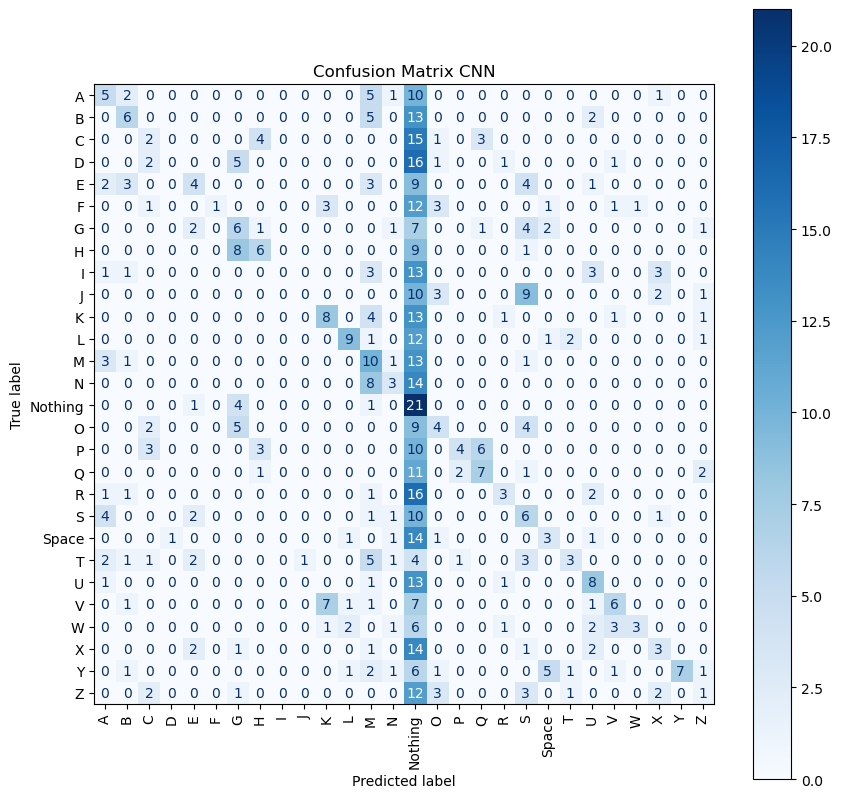

In [24]:
predictions, targets = cnn_results
show_confusion_matrix(targets, predictions, title="Confusion Matrix CNN")

In [18]:
evaluation() # Without our own pictures

wandb:   1 of 1 files downloaded.  
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9642857313156128
        test_loss           0.08273524045944214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.96429
test_loss,0.08274
trainer/global_step,0
